### Schrödinger equation using implicit method ###
We want to solve:
\begin{align}
    -i\frac{du}{dt} = \Delta u + V
\end{align}
in a unit square $\Omega$. With Dirichlet boundary condtions:

\begin{align}
u|_{\partial\Omega} = 0
\end{align}

and initial conditions

\begin{align}
u(t=0) = u_0
\end{align}

We choose $V=0$ for now.

To use real functions we define a two vector $u=(u_r,u_i)$, and the the system is:

\begin{equation}
\frac{d}{dt}\left(
    \begin{array}{c}
    u_r \\
    u_i
    \end{array}
    \right)
    = 
    \left(
    \begin{array}{cc}
    0 & \Delta \\
    -\Delta & 0
    \end{array}
    \right)
    \left(
    \begin{array}{c}
    u_r \\
    u_i
    \end{array}
    \right)
\end{equation}


Which we discretize as:

\begin{equation}
    \left(
    \begin{array}{c}
    u_r \\
    u_i
    \end{array}
    \right)^{n+1}
    = \left(
    \begin{array}{c}
    u_r \\
    u_i
    \end{array}
    \right)^{n}
    +
    \Delta t \left(
    \begin{array}{cc}
    0 & \Delta \\
    -\Delta & 0
    \end{array}
    \right)
    \left(
    \begin{array}{c}
    u_r \\
    u_i
    \end{array}
    \right)^{n+1}
\end{equation}

That is, 

\begin{equation}
    \left(
    \begin{array}{c}
    u_r \\
    u_i
    \end{array}
    \right)^{n+1}
    =  \left(
    \begin{array}{cc}
    1 & -\Delta t\Delta \\
    +\Delta t \Delta & 1
    \end{array}
    \right)^{-1}
    \left(
    \begin{array}{c}
    u_r \\
    u_i
    \end{array}
    \right)^{n}
\end{equation}


We write this system in the weak form as:

\begin{align}
\int (v_r u_r + v_i u_i + dt (\nabla v_r \cdot \nabla u_i - \nabla v_i \cdot \nabla u_r) - (v_r u^n_r + v_i u^n_i))dV
\end{align}

where $u=u^{n+1}$.
But this scheme is too dissipative, with reasonable time-steps decays very fast and the wave disappears. 

To avoid this we do a semi implicit method, namely 

\begin{align}
\int (v_r u_r + v_i u_i + \frac{dt}{2} (\nabla v_r \cdot \nabla u_i - \nabla v_i \cdot \nabla u_r) - (v_r u^n_r + v_i u^n_i - \frac{dt}{2} (\nabla v_r \cdot \nabla u^n_i - \nabla v_i \cdot \nabla u^n_r))dV
\end{align}

For this case the operator is:

\begin{align}
\left(
    \begin{array}{cc}
    1 & -\frac{\Delta t}{2}\Delta \\
    +\frac{\Delta t}{2} \Delta & 1
    \end{array}
\right)^{-1}
\left(
    \begin{array}{cc}
    1 & +\frac{\Delta t}{2}\Delta \\
    -\frac{\Delta t}{2} \Delta & 1
    \end{array}
\right)
\end{align}

And this operator has norm 1.

In [49]:
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as mpl

We have several cases, in particular a test case to check the algorithm and the a double slit experiment, where we allow a wave to leak across two small apertures into another region. 

In [50]:
slit = False
test = False
slit = True
#test = True

In [51]:
if slit:
    T = 0.20            # final time
    #num_steps = 160     # number of time steps (para 256)
    #n_save = 10            # save every n_save steps
    num_steps = 80     # number of time steps (para 128)
    n_save = 5            # save every n_save steps    Dt = T / num_steps # time step size
    omega_x = 8.          # parameter alpha
    omega_y = 1.         # parameter beta
    beta = 8.

if test:
    T = 2.0            # final time
    num_steps = 80     # number of time steps
    n_save = 5            # save every n_save steps
    Dt = T / num_steps # time step size
    omega_x = 5.          # parameter alpha
    omega_y = 1.         # parameter beta
    beta = 0.


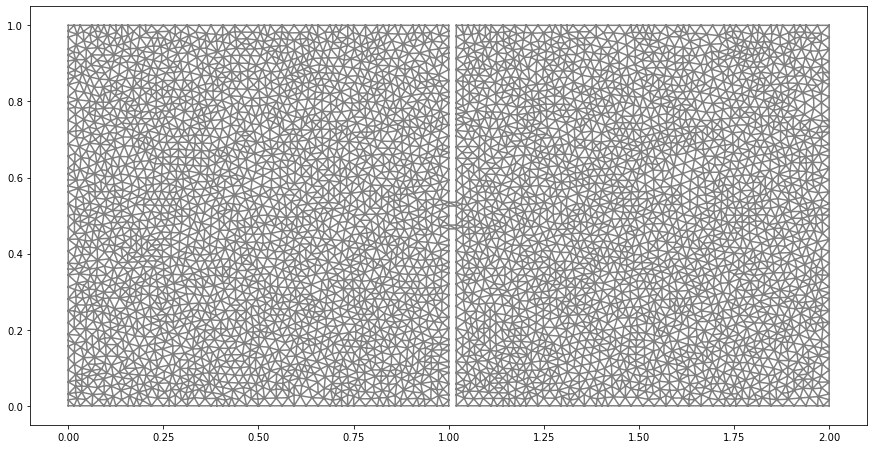

In [52]:
if slit:
    length_x = 2.
    length_y = 1.
    l_slit = 0.05
    width = 0.02
    gap = 0.01

    #center_x = 0.4
    #center_y = 0.4 #width / 2.
    #radious = 0.05 #width / 4.
    
    channel = Rectangle(Point(0, 0), Point(length_x, length_y))
    slit_1 = Rectangle(Point(length_x/2., 0), Point(length_x/2.+width, length_y/2.-l_slit/2.-gap))
    slit_2 = Rectangle(Point(length_x/2., length_y/2.-l_slit/2.), Point(length_x/2.+width, length_y/2.+l_slit/2.))
    slit_3 = Rectangle(Point(length_x/2., length_y/2.+l_slit/2+gap), Point(length_x/2.+width, length_y))
    #cylinder = Circle(Point(center_x, center_y), radious)
    #domain = channel - cylinder

    domain = channel - slit_1 - slit_2 - slit_3

    mesh = generate_mesh(domain, 64)
    #mesh = generate_mesh(domain, 128)
    #mesh = generate_mesh(domain, 254)
if test:
    mesh = UnitSquareMesh(20,20)
# Plot mesh
mpl.figure(figsize=(15,20))
plot(mesh)

To represent the complex field we use two-vectors the first component being the real part and so on. 

In [53]:
# Define function space

V = VectorFunctionSpace(mesh, 'CG', 2)

For boundary conditions we take Dirichlet, implying the box is closed. It would be interesting to do a case where a flux is present, incomming from the left and leaving at the right. 

In [54]:
tol = 1.E-4

def boundary(x, on_boundary):
            return on_boundary
bc = DirichletBC(V, Constant(('0.0','0.0')), boundary)


Next we define the initial conditions and assign it to a vector wich we then use in the evolution scheme. 

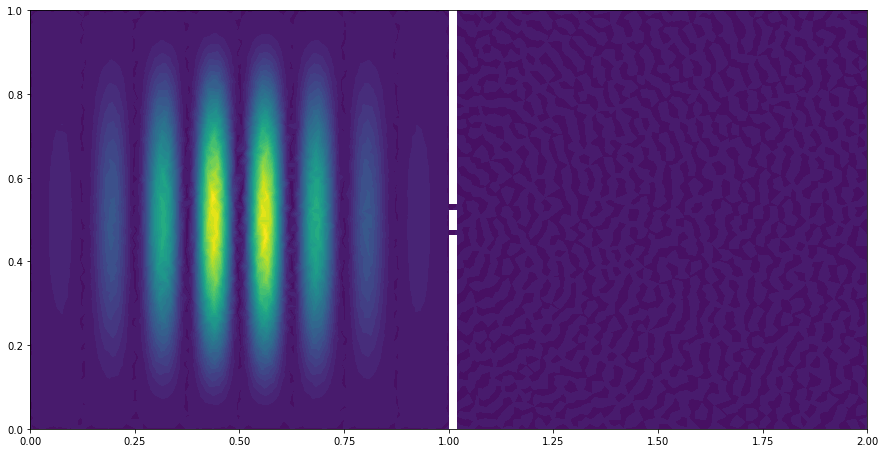

In [55]:
# Define initial value

#u_0 = Expression(('sin(pi*omega_x*x[0])*sin(pi*omega_y*x[1])*exp(-x[0]*x[0]*beta)', '0'),
#                 degree=2, omega_x=omega_x, omega_y=omega_y, beta=beta)

u_0 = Expression(('(x[0]<=1.)? sin(pi*omega_x*x[0])*sin(pi*omega_y*x[1])*exp(-(x[0]-0.5)*(x[0]-0.5)*beta) : 0.', '(x[0]<=1.)? -sin(pi*omega_x*x[0])*sin(pi*omega_y*x[1])*exp(-(x[0]-0.5)*(x[0]-0.5)*beta): 0.0'),
                 degree=2, omega_x=omega_x, omega_y=omega_y, beta=beta)

u_n = Function(V)
u_n.assign(u_0)

mpl.figure(figsize=(15,20))
plot(dot(u_n,u_n))
#plot(grad(u_n[0]))
#plot(u_n[1])
#plot(mesh)

Next we define the scheme we are going to evolve. The direct scheme is Euler explicit, that we know it would be unstable. We then try Euler implicit, which is stable, but too dissipative, requiring very small time steps. Finally we present the one that is appropriate for the case, which has amplification factor of 1, half explicit, half implicit.

In [46]:
# Define variational problem
v = TestFunction(V)
u = TrialFunction(V)

Euler_expl = False
Euler_impl = False
Euler_mid = False
#Euler_expl = True
#Euler_impl = True
Euler_mid = True

if Euler_impl:
    a = dot(u,v)*dx + Dt*(dot(grad(v[0]),grad(u[1])) - dot(grad(v[1]),grad(u[0])))*dx 
    L = dot(u_n,v)*dx
    
if Euler_mid:
    a = (u[0]*v[0]+u[1]*v[1] + Dt/2.*(dot(grad(v[0]),grad(u[1])) - dot(grad(v[1]),grad(u[0]))))*dx 
    L = (u_n[0]*v[0]+u_n[1]*v[1] - Dt/2.*(dot(grad(v[0]),grad(u_n[1])) - dot(grad(v[1]),grad(u_n[0]))) )*dx

if Euler_expl:
    a = (u[0]*v[0]+u[1]*v[1] )*dx 
    L = (u_n[0]*v[0]+u_n[1]*v[1] - Dt*(dot(grad(v[0]),grad(u_n[1])) - dot(grad(v[1]),grad(u_n[0]))) )*dx


In [47]:
if test:
#    vtkfile_u = File('Schrodinger/test_E_expl_g.pvd')
#    vtkfile_u = File('Schrodinger/test_E_impl_g.pvd')
    vtkfile_u = File('Schrodinger/test_E_mid_g.pvd')
if test==False: 
    vtkfile_u = File('Schrodinger/s64_g.pvd')
    #vtkfile_u = File('Schrodinger/s128_g.pvd')
    #vtkfile_u = File('Schrodinger/s256_g.pvd')

0.4995677981129906
0.49956779811304475
0.4995677981130978
0.4995677981131484
0.4995677981131975
0.4995677981132507
0.4995677981132997
0.4995677981133516
0.4995677981134017
0.49956779811345053
0.4995677981134978
0.4995677981135479
0.4995677981136011
0.49956779811365437
0.49956779811370944
0.49956779811376895


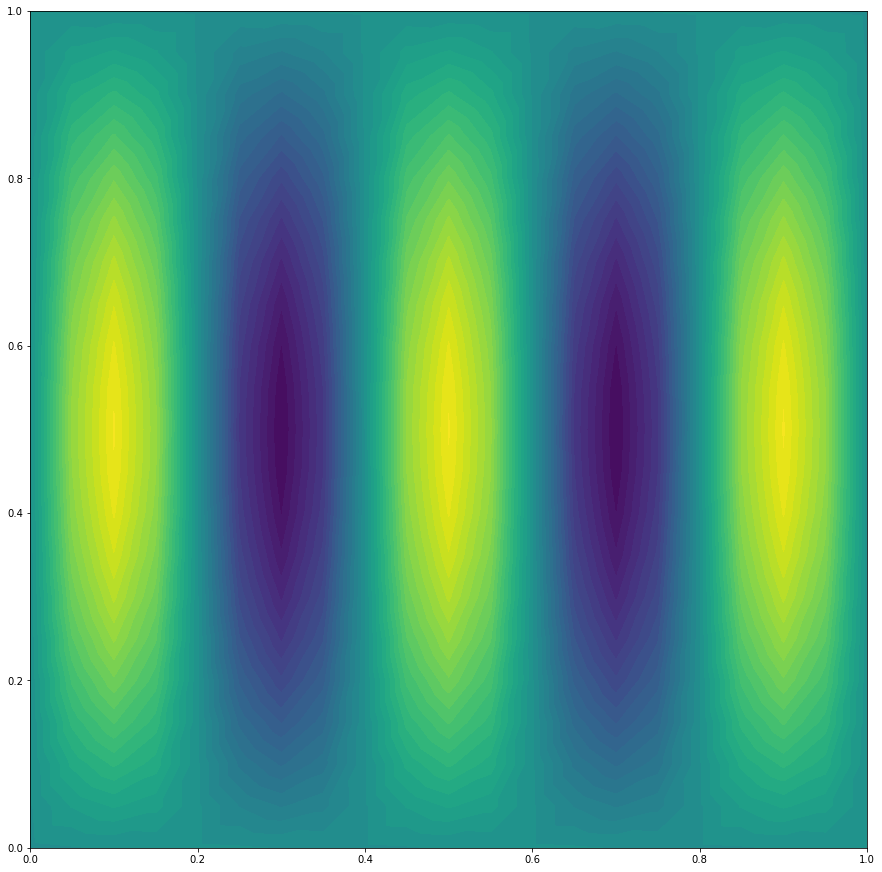

In [48]:
# Time-stepping
u_n.assign(u_0)
u = Function(V, name = 'wave')
t = 0
#Dt = 0.00001
for n in range(num_steps):

    # Update current time
    t += Dt
    #u_B.t = t
    #f.t = t

    # Compute solution
    solve(a == L, u, bc)
    
    #save only every n_save steps
    if (n%n_save==0):
        vtkfile_u << u
        print(assemble(dot(u,u)*dx))
        
    # Update previous solution
    u_n.assign(u)


mpl.figure(figsize=(15,20))
plot(u[0])

## To DO ##

1. plot with norm preservation.
2. compute and plot energy conservation.
3. compute error for test (u - u_e)
4. add potential and other cases of interest